# Importing libraries

In [0]:
import pandas as pd
import numpy as np
import gzip
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.python.ops import rnn, rnn_cell
from tensorflow.contrib.rnn import stack_bidirectional_dynamic_rnn

%matplotlib inline

tf.set_random_seed(1234)
np.random.seed(1234)

# Reading Data file

In [0]:
with gzip.open("file_name", 'rb') as ifp:
    df = pickle.load(ifp)

                                                MFCC                 name Label  lengths
0  [[17.178007859968, 6.6467205680758585, -17.290...  Ses01M_impro01_F022   ang     1068
1  [[14.600711836560647, 7.653237680037131, -4.85...  Ses01M_impro01_M003   neu      247
2  [[12.207307357324005, -0.05423970880662275, -9...  Ses01M_impro01_M017   fru      272
3  [[13.49571431766749, -3.7515978564356445, -4.0...  Ses01M_impro01_M016   fru      210
4  [[15.200732369996961, -23.793255016290864, -21...  Ses01M_impro01_M002   fru      310

Total Data size: 7028
Male Samples: 3666
Female Samples: 3362

Emotion-wise samples


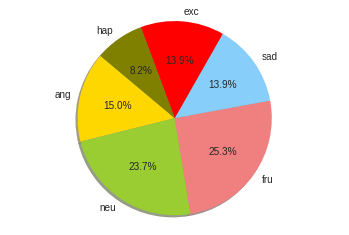

array(['ang', 'exc', 'fru', 'hap', 'neu', 'sad'], dtype=object)

In [6]:
pd.set_option('display.width', 100)
print(df.head())

df.reset_index(inplace=True)
df.drop('index', inplace=True, axis=1)

male = 0
female = 0
for index, row in df['name'].iteritems():
    if row[-4] == 'F':
        female +=1
    else:
        male +=1
        
print('\nTotal Data size:', df.shape[0])
print('Male Samples:', male)
print('Female Samples:', female)
print('\nEmotion-wise samples')

emo_name = []
emo_number = []
for i in df['Label'].unique():
    emo_name.append(i)
    emo_number.append(np.sum(df['Label'] == i))
plt.pie(emo_number, labels=emo_name, colors=['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'red', 'olive'],
        autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')
plt.show()
    
le = LabelEncoder()
le.fit(df['Label'].values)
le.classes_

# Splitting Data

In [14]:
df_train, df_test = train_test_split(df, test_size=0.15, random_state=0)
print('training samples:', df_train.shape[0])
print('test samples:', df_test.shape[0])

training set examples 5973
test set examples 1055


# Bucket Iterator

In [0]:
class BucketedDataIterator():
    def __init__(self, df, num_buckets = 14):
        df = df.sort_values('lengths').reset_index(drop=True)
        self.size = len(df) / num_buckets
        self.dfs = []
        for bucket in range(num_buckets):
            self.dfs.append(df.loc[bucket*self.size: (bucket+1)*self.size - 1])
        self.num_buckets = num_buckets

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.shuffle()

        self.epochs = 0

    def shuffle(self):
        #sorts dataframe by sequence length, but keeps it random within the same length
        for i in range(self.num_buckets):
            self.dfs[i] = self.dfs[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0

    def next_batch(self, n):
        if np.any(self.cursor+n+1 > self.size):
            self.epochs += 1
            self.shuffle()

        i = np.random.randint(0,self.num_buckets)

        res = self.dfs[i].loc[self.cursor[i]:self.cursor[i]+n-1]
        self.cursor[i] += n

        # Pad sequences with 0s so they are all the same length
        maxlen = int(max(res['lengths']))
        
        x = np.zeros([n, maxlen, 20], dtype=np.float)
        for i, x_i in enumerate(x):
            x_i[:res['lengths'].values[i]] = res['MFCC'].values[i]

        return x, le.transform(res['Label'].values), res['lengths']

In [9]:
tr = BucketedDataIterator(df)
mini_batch = tr.next_batch(128)
X = mini_batch[0]
y = mini_batch[1]
seqlen = mini_batch[2]
print('X shape:', X.shape)
print('Target:', y[:5])
print('Sequence length:\n', seqlen[:5])

X shape: (128, 391, 20)
Target: [2 4 2 0 5]
Sequence length:
 0    359
1    370
2    379
3    359
4    363
Name: lengths, dtype: int64


# Tensorflow Models

In [0]:
# some hyperparameters
hm_epochs = 100
n_classes = 6
batch_size = 128
learning_rate = 0.01
num_mfcc_features = 20
rnn_size = 128
dropout = 0.8

# resets tensorflow graph
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

# model graph
def rnn_model():
    
    # resets the previous graph
    reset_graph()

    # defining placeholders
    x = tf.placeholder(tf.float32,[batch_size, None, num_mfcc_features])
    y = tf.placeholder(tf.int32, [batch_size])
    seq_length = tf.placeholder(tf.int32, [batch_size])
    keep_prob = tf.placeholder(tf.float32)
  
    layer = {'weights':tf.Variable(tf.random_normal([rnn_size*2, n_classes])),
            'biases':tf.Variable(tf.random_normal([n_classes]))}
        
    # single RNN layer
    lstm_fw_cell = rnn_cell.BasicLSTMCell(rnn_size)
    lstm_bw_cell = rnn_cell.BasicLSTMCell(rnn_size)
    rnn_outputs, final_state_fw, final_state_bw = stack_bidirectional_dynamic_rnn([lstm_fw_cell], [lstm_bw_cell], x, dtype=tf.float32, sequence_length=seq_length)
   
    rnn_outputs = tf.nn.dropout(rnn_outputs, keep_prob)
    
    # stacking the outputs of all time frames
    last_rnn_output = tf.gather_nd(rnn_outputs, tf.stack([tf.range(batch_size), seq_length-1], axis=1))
    
    output = tf.add(tf.matmul(last_rnn_output, layer['weights']), layer['biases'])
    
    # predicting labels
    preds = tf.nn.softmax(output)
    
    # calculating accuracy
    correct = tf.equal(tf.argmax(preds,1), tf.argmax(tf.one_hot(y,6),1))
    accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

    # calculating loss
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=output, labels=tf.one_hot(y,6)))

    # adding optimizer
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

    return {'x': x, 'seqlen': seq_length, 'y': y, 'loss': cost, 'preds': preds, 'accuracy': accuracy, 'dropout': keep_prob, 'optimizer': optimizer}
  
def train_model(graph):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        tr = BucketedDataIterator(df)
        te = BucketedDataIterator(df)

        step, accuracy, loss = 0, 0, 0
        tr_acc, te_acc, tr_loss, te_loss = [], [], [], []
        current_epoch = 0
        while current_epoch < hm_epochs:
            step += 1
            mini_batch = tr.next_batch(batch_size)
            _, accuracy_, loss_ = sess.run([graph['optimizer'], graph['accuracy'], graph['loss']], feed_dict = {graph['x']: mini_batch[0], graph['y']: mini_batch[1], 
                                                                        graph['seqlen']: mini_batch[2], graph['dropout']: dropout})
            accuracy += accuracy_
            loss += loss_ 
            
            if tr.epochs > current_epoch:
                current_epoch += 1
                tr_acc.append(accuracy / step)
                tr_loss.append(loss / step)
                step, accuracy, loss = 0, 0, 0

                #eval test set
                te_epoch = te.epochs
                while te.epochs == te_epoch:
                    step += 1
                    mini_batch = te.next_batch(batch_size)
                    _, accuracy_, loss_ = sess.run([graph['optimizer'], graph['accuracy'], graph['loss']], feed_dict = {graph['x']: mini_batch[0], graph['y']: mini_batch[1], 
                                                                        graph['seqlen']: mini_batch[2], graph['dropout']: 1})
                    accuracy += accuracy_
                    loss += loss_

                te_acc.append(accuracy / step)
                te_loss.append(loss / step)
                step, accuracy, loss = 0, 0, 0
                
                print("Epoch: %d/%d\nloss: %0.4f - acc: %.4f - val_loss: %.4f - val_acc: %.4f" % (current_epoch, hm_epochs, tr_loss[-1], tr_acc[-1], te_loss[-1], te_acc[-1]))

    return tr_acc, tr_loss, te_acc, te_loss

In [24]:
g = rnn_model()
tr_acc, tr_loss, te_acc, te_loss = train_model(g)

Epoch: 1/100
loss: 7.0778 - acc: 0.1905 - val_loss: 2.2739 - val_acc: 0.2510
Epoch: 2/100
loss: 2.6232 - acc: 0.1916 - val_loss: 1.8508 - val_acc: 0.2539
Epoch: 3/100
loss: 2.4311 - acc: 0.2156 - val_loss: 1.7539 - val_acc: 0.2859
Epoch: 4/100
loss: 2.3810 - acc: 0.1889 - val_loss: 1.6731 - val_acc: 0.3004
Epoch: 5/100
loss: 2.1895 - acc: 0.2270 - val_loss: 1.6927 - val_acc: 0.2824
Epoch: 6/100
loss: 2.0601 - acc: 0.2445 - val_loss: 1.7108 - val_acc: 0.2752
Epoch: 7/100
loss: 2.0521 - acc: 0.2127 - val_loss: 1.6852 - val_acc: 0.3089
Epoch: 8/100
loss: 2.0303 - acc: 0.2383 - val_loss: 1.6104 - val_acc: 0.3203
Epoch: 9/100
loss: 1.9245 - acc: 0.2565 - val_loss: 1.6537 - val_acc: 0.3299
Epoch: 10/100
loss: 1.8893 - acc: 0.2715 - val_loss: 1.5959 - val_acc: 0.3352
Epoch: 11/100
loss: 1.7957 - acc: 0.3078 - val_loss: 1.6187 - val_acc: 0.3175
Epoch: 12/100
loss: 1.8005 - acc: 0.3099 - val_loss: 1.5166 - val_acc: 0.3781
Epoch: 13/100
loss: 1.8316 - acc: 0.2587 - val_loss: 1.5472 - val_acc: 0.

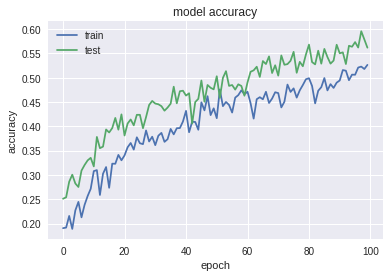

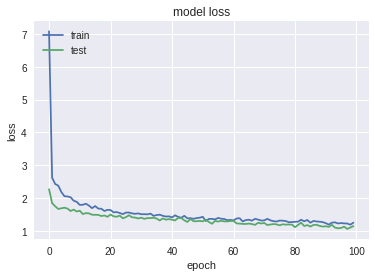

In [25]:
# summarize history for accuracy
plt.plot(np.arange(len(tr_acc)), tr_acc)
plt.plot(np.arange(len(tr_acc)), te_acc)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.arange(len(tr_loss)), tr_loss)
plt.plot(np.arange(len(tr_loss)), te_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()